# IMPORT LIBRARY AND DATA

In [1]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee']) # Ini kudu install install dulu

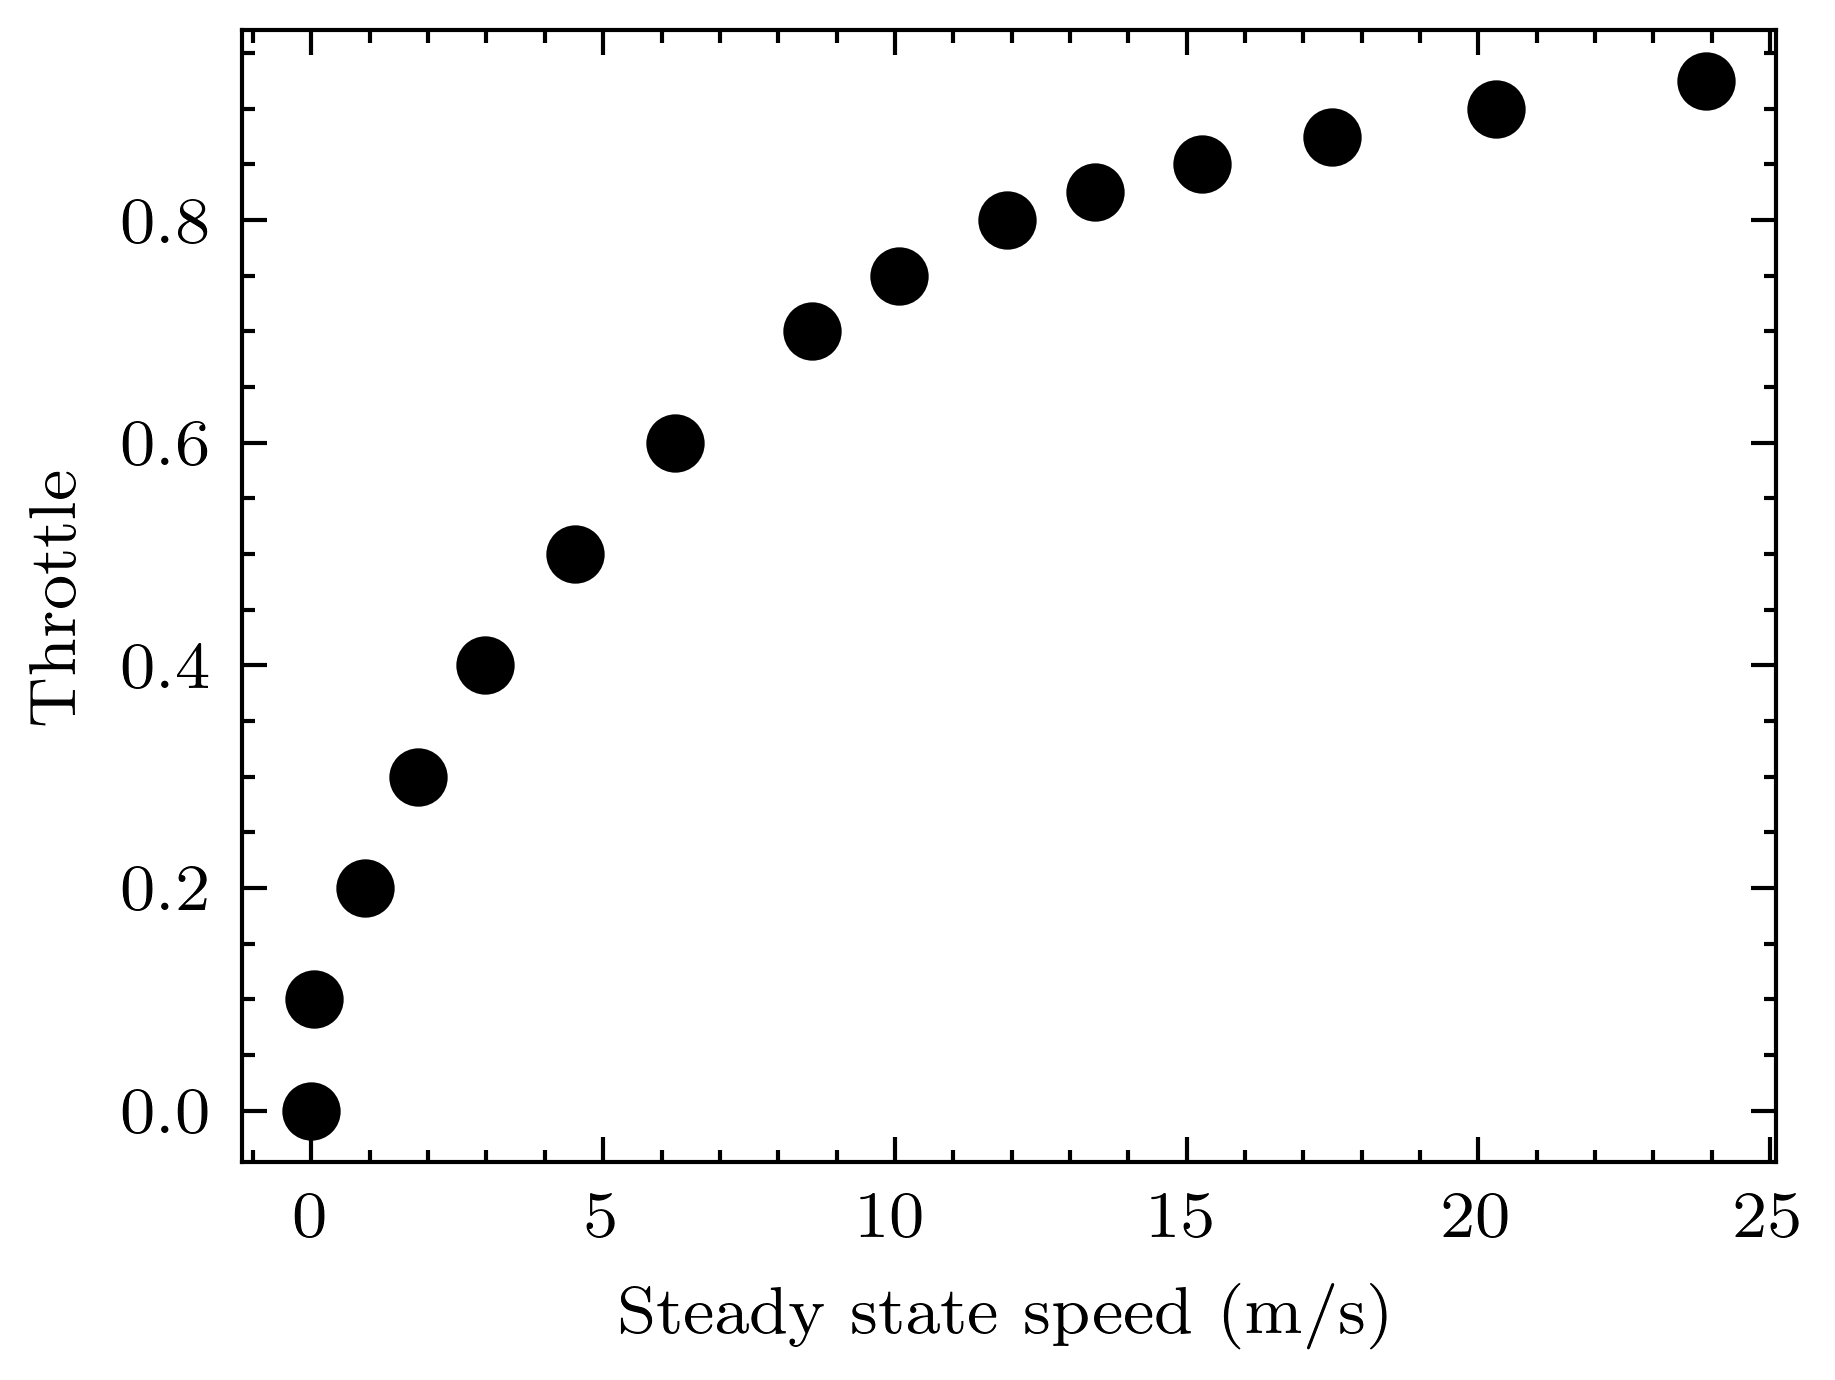

In [2]:
df = pd.read_csv('../steady_state_response.csv')
v = np.array(df.ssv)
u = np.array(df.u)

plt.figure()
plt.scatter(v, u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.show()

# MAKE FUNCTION

## Generate population

In [3]:
def generate_population(num, dim, rng):
    """
    Generate flowers:
        Input:
            num: number of flowers (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            flws: initial position of the flowers (numpy array)
    """
    flws = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        flws[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return flws

## Constraint

In [4]:
@njit
def admissible(param):
    b1, b2, b3 = param
    if b1 < 0. or b2 > 0. or b3 < 0.:
        return False
    else:
        return True
_ = admissible(np.random.randn(3))

## Forward propagation

In [5]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

## Cost and metric

In [6]:
@njit
def cost(u, v, param):
    error = v - forward_propagation(u, param)
    cost = np.mean(error**2)
    return cost
_ = cost(v, u, np.ones(3)*0.5)

In [7]:
@njit
def calculate_total_cost(param):    
    if admissible(param):
        loss = cost(v, u, param)
    else:
        loss = np.Inf
    return loss
_ = calculate_total_cost(np.ones(3)*0.5)

In [8]:
@njit(parallel=True)
def flowers_cost(flowers):
    length = flowers.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(flowers[ii])
    return losses
_ = flowers_cost(np.random.randn(2,3))

## Optimization Algorithm

In [9]:
@njit(parallel = True)
def fpa(flowers, loss_flowers, global_, global_loss_, p, alpha, gamma, var, s0):
    num = flowers.shape[0]
    dim = flowers.shape[1]    
    out = np.empty(flowers.shape)
    temp = np.empty(dim)
    loss = np.empty(loss_flowers.shape)
    temp_loss = 0.
    random_number = np.random.uniform(0., 1., num)
    for i in prange(num):
        # GLOBAL POLLINATION
        if random_number[i] < p:
            # Generate Levy Flight
            upper = np.random.normal(0., np.sqrt(var), size=dim)
            lower = np.abs(np.random.normal(0., 1., size=dim))**(1./alpha)
            L = np.divide(upper, lower)
            
            for j in range(L.shape[0]):
                if L[j] < s0:
                    L[j] = s0
            
            temp = flowers[i] + gamma * L * (global_ - flowers[i])
        # LOCAL POLLINATION
        else:
            while(True):
                i1, i2 = np.random.randint(0, num, size=2)
                if i1==i2 or i1==i or i2==i:
                    if num <= 5: # For breaking the loop
                        None
                    else:
                        continue
                break
            epsilon = np.random.uniform(0.,1.)
            
            temp = flowers[i] + epsilon * (flowers[i1] - flowers[i2])
        
        # CALCULATE COST
        temp_loss = calculate_total_cost(temp)
        if np.isnan(temp_loss):
            temp_loss = np.Inf
        
        # UPDATE
        if temp_loss < loss_flowers[i]:
            out[i] = temp
            loss[i] = temp_loss
        else:
            out[i] = flowers[i]
            loss[i] = loss_flowers[i]
    
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    if global_loss_ > min_loss:
        global_loss_new = min_loss
        global_new = out[min_idx, :]
    else:
        global_new = global_
        global_loss_new = global_loss_
    
    return out, loss, global_new, global_loss_new

xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = fpa(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1, 0.69, 0.1)

# SIMULATION

In [10]:
num = 25
n_sim = 50
n_itr = 5000

r_b1 = [0.,  2.]
r_b2 = [0., -2.]
r_b3 = [0.,  2.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

s0 = 0.1
p_threshold = 0.8
alpha = 1.5
gamma = 0.1
var = (math.gamma(1+alpha)/alpha/math.gamma((1+alpha)/2) * np.sin(np.pi * alpha/2)/2**((alpha-1)/2))**(1/alpha)

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim) * np.Inf

the_best_param_history = np.zeros((n_itr, dim))
the_best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    flowers = generate_population(num, dim, rng)
    global_ = None
    global_loss_ = np.Inf

    loss_flowers = flowers_cost(flowers)
    loss_flowers[np.isnan(loss_flowers)] = np.Inf
    min_idx = np.argmin(loss_flowers)
    min_loss = loss_flowers[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = np.copy(flowers[min_idx, :])

    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Flower Pollination Algorithm
        flowers, loss_flowers, global_, global_loss_ = fpa(flowers, loss_flowers, global_, global_loss_, p_threshold, alpha, gamma, var, s0)

        # print('iteration: {} || global_loss: {:.5f}'.format(i, global_loss_))

        global_history[i] = global_
        global_loss_history[i] = global_loss_

    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || global loss: {:.10f} || the best loss: {:.10f}'.format(j, global_loss_history[-1], the_best_loss_history[-1]))

simulation: 0 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 1 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 2 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 3 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 4 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 5 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 6 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 7 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 8 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 9 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 10 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 11 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 12 || global loss: 0.0000117460 || the best loss: 0.0000117460
simulation: 13 || global loss: 0.00

In [11]:
# Save the simulation
np.save('result/param_history.npy', param_history)
np.save('result/loss_history.npy', loss_history)
np.save('result/the_best_loss_history.npy', the_best_loss_history)
np.save('result/the_best_param_history.npy', the_best_param_history)

f = open("result/sim.cfg", "w+")
f.writelines('num: {} # The number of flowers\n'.format(num))
f.writelines('n_sim: {} # The number of simulation loop\n'.format(n_sim))
f.writelines('n_itr: {} # The number of iteration for each simulation\n'.format(n_itr))
f.writelines('\n# The boundary of the initialization value\n')
f.writelines('r_b1: {}\n'.format(r_b1))
f.writelines('r_b2: {}\n'.format(r_b2))
f.writelines('r_b3: {}\n'.format(r_b3))
f.writelines('\n# The FPA hyperparameters\n')
f.writelines('s0: {}\n'.format(s0))
f.writelines('p_threshold: {}\n'.format(p_threshold))
f.writelines('alpha: {}\n'.format(alpha))
f.writelines('gamma: {}\n'.format(gamma))
f.writelines('var: {}\n'.format(var))
f.close()

# RESULT

In [12]:
# # Load the model
the_best_param_history = np.load('result/the_best_param_history.npy')
the_best_loss_history = np.load('result/the_best_loss_history.npy')

In [13]:
print('Minimum Cost: {}'.format(the_best_loss_history[-1]))
print('Parameters:')
print(the_best_param_history[-1])

Minimum Cost: 1.1745972296653406e-05
Parameters:
[ 0.85009553 -0.14497243  0.09623465]


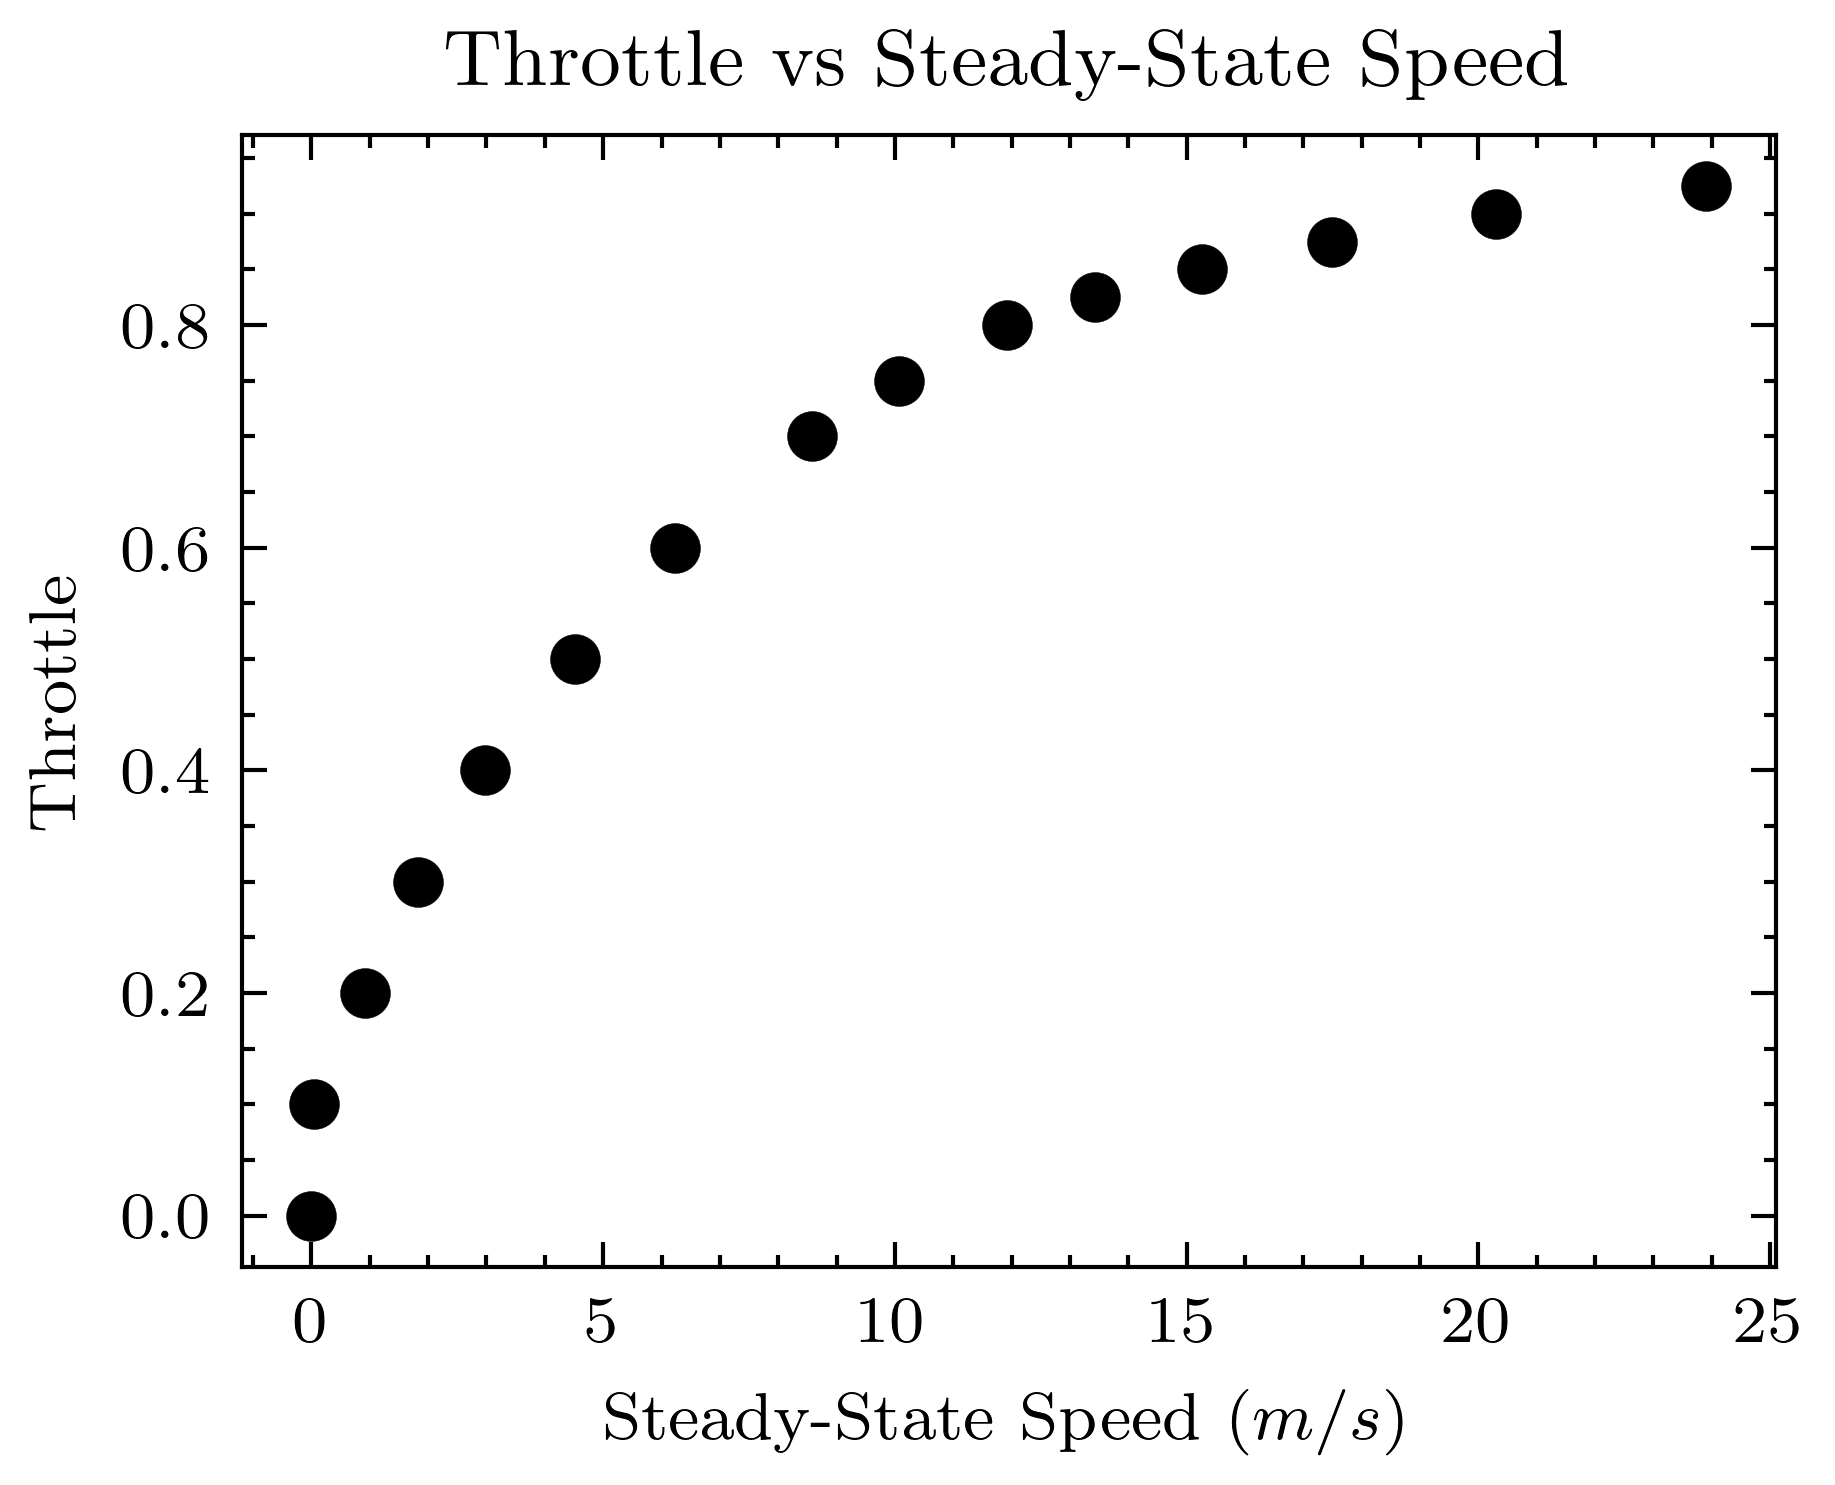

In [14]:
plt.scatter(v, u, linewidth=0.05)
plt.xlabel(r'Steady-State Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Throttle vs Steady-State Speed')
plt.savefig('img/throttle_vs_speed', dpi=600, transparent=True, bbox_inches='tight',)
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


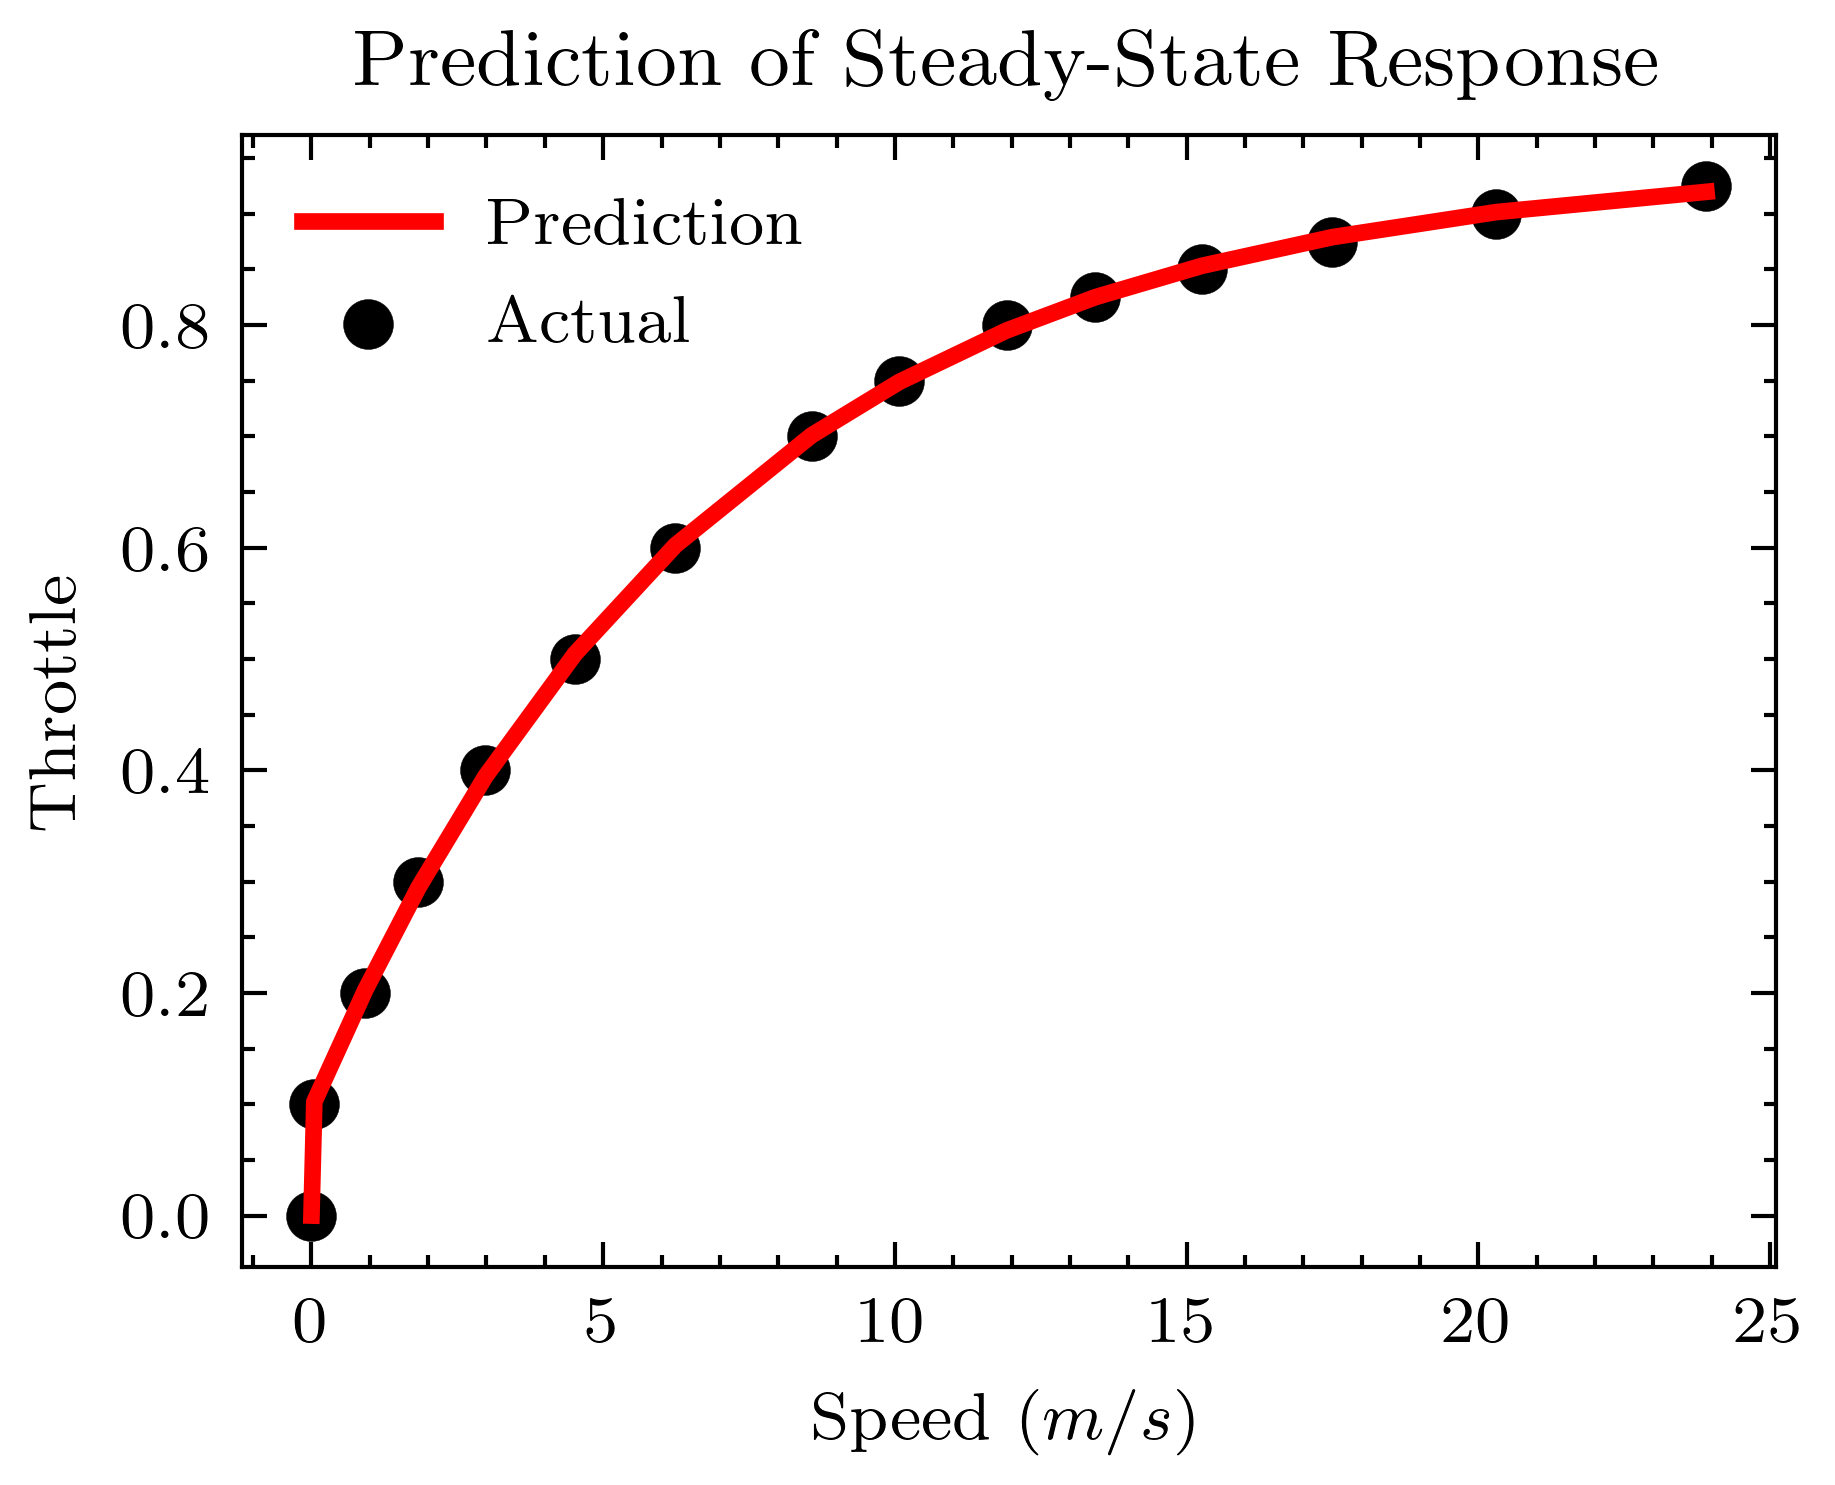

In [15]:
plt.scatter(v, u, label='Actual', linewidth=0.05)
plt.plot(v, forward_propagation(v, the_best_param_history[-1]), label='Prediction', color='red', linewidth=2)
plt.xlabel(r'Speed $(m/s)$')
plt.ylabel('Throttle')
plt.title('Prediction of Steady-State Response')
plt.legend()
plt.savefig('img/throttle_vs_speed_pred', dpi=600, transparent=True, bbox_inches='tight')
plt.show()